In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import pymc3 as pm
import arviz as az
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [3]:
d = pd.read_csv("data/howell1.csv", sep=";")

In [4]:
d.head()
d2 = d[d.age >= 18]

In [5]:
num_samples = 10000
samples_sigma = stats.uniform.rvs(size=num_samples, loc=0, scale=50)
samples_mu = stats.norm.rvs(size=num_samples, loc=178, scale=20)
prior_h = stats.norm.rvs(size=num_samples, loc=samples_mu, scale=samples_sigma)

/var/folders/5y/qjwg__qs30d10cqddlwnmbvm0000gn/T/ipykernel_94801/2717740093.py:1: DeprecationWarning: The function `kdeplot` from PyMC3 is just an alias for `plot_kde` from ArviZ. Please switch to `pymc3.plot_kde` or `arviz.plot_kde`.
  pm.kdeplot(prior_h)


<AxesSubplot:>

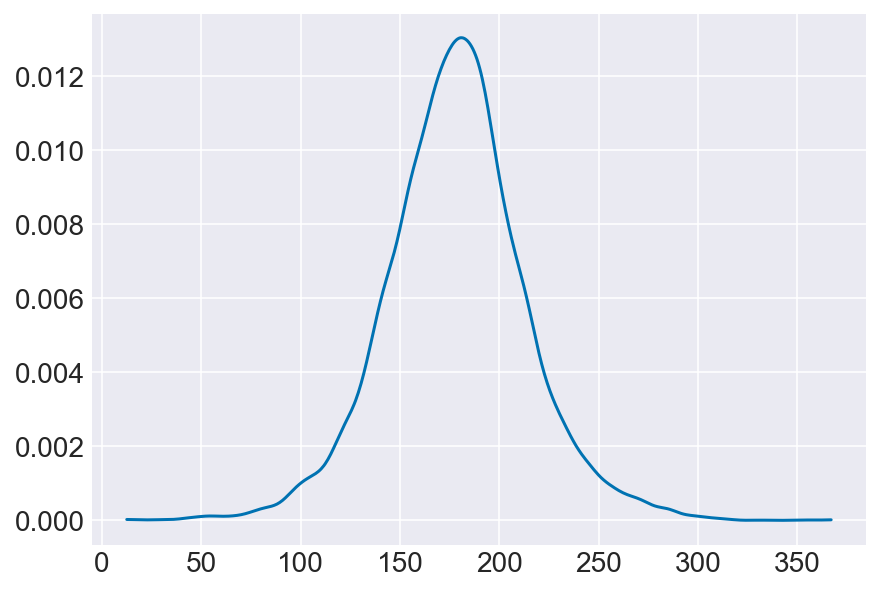

In [6]:
pm.kdeplot(prior_h)

(-120.0, 450.0)

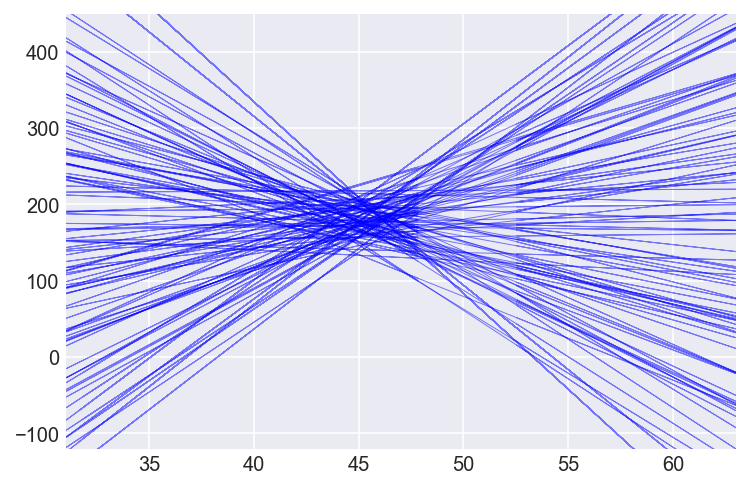

In [7]:
N = 100
a = np.random.normal(size=N, loc=178, scale=20)
b = np.random.normal(size=N, loc=0, scale=10)

x = d2.weight.values
for i in range(N):
    y = (a[i] + b[i] * (d2.weight - d2.weight.mean())).values
    slope, intercept, _, _, _ = stats.linregress(x, y)

    plt.plot(x, y, c="blue", lw=.5, alpha=0.5)
plt.xlim(x.min(), x.max())
plt.ylim(-120, 450)

(-120.0, 450.0)

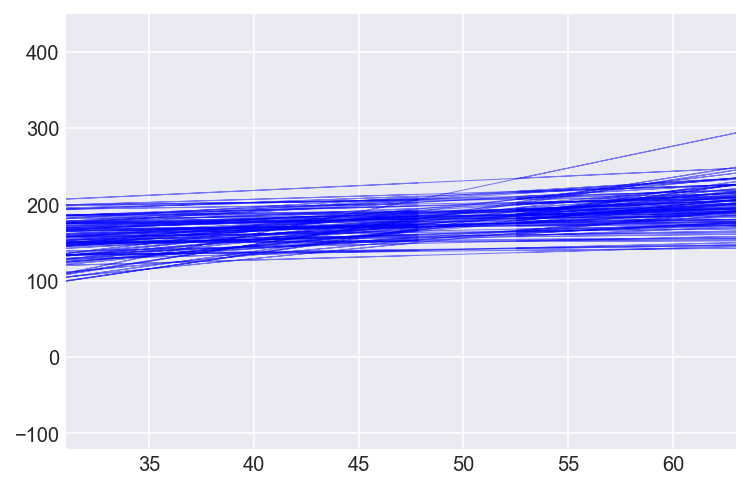

In [8]:
N = 100
a = np.random.normal(size=N, loc=178, scale=20)
b = np.random.lognormal(size=N, mean=0, sigma=1)

x = d2.weight.values
for i in range(N):
    y = (a[i] + b[i] * (d2.weight - d2.weight.mean())).values
    slope, intercept, _, _, _ = stats.linregress(x, y)

    plt.plot(x, y, c="blue", lw=.5, alpha=0.5)
plt.xlim(x.min(), x.max())
plt.ylim(-120, 450)
    

# Exercises

### 4M1

For the model definition below, simulate observed y values from the prior (not the posterior).

$y \sim Normal(\mu, \sigma)$  
$\mu \sim Normal(0, 10)$  
$\sigma \sim Exponential(1)$

<AxesSubplot:>

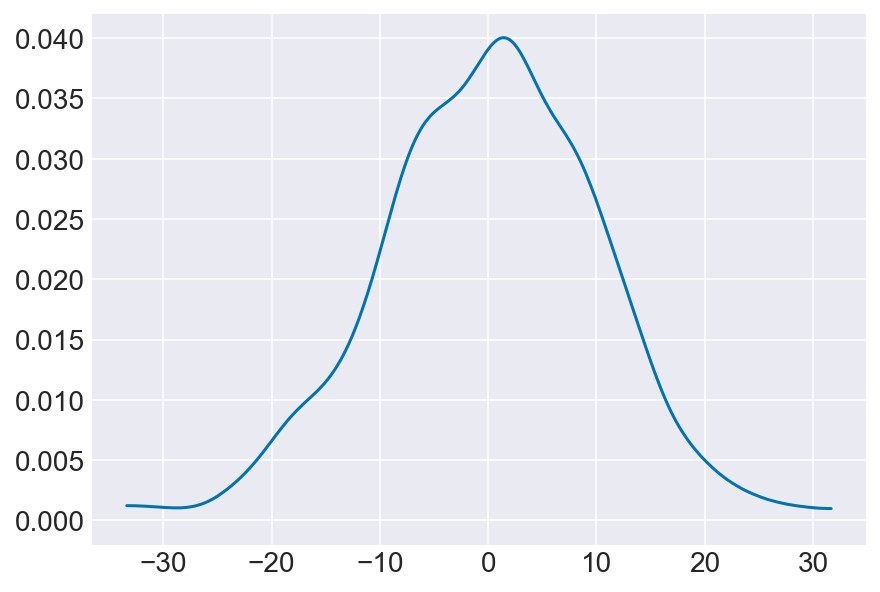

In [246]:
N = 1000
mu = np.random.normal(size=N, loc=0, scale=10)
sigma = np.random.exponential(size=N, scale=1)
y = np.random.normal(size=N, loc=mu, scale=sigma)

pm.plot_kde(y)

### 4M2

Trasnlate the model just above into a quap formula.

(Instead I'm going to use pymc3 as I'm using python).

In [ ]:
with pm.Model("model1") as model:
    mu = pm.Normal("mu", mu=0, sd=10)
    sigma = pm.Exponential("sigma", lam=1)
    y = pm.Normal("y", mu=mu, sd=sigma)

### 4M4

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

```
h = Normal(mu, sigma)
mu = alpha + beta * (year - yearbar)
alpha = Normal(100, 10)
beta = Normal(0, 10)
sigma = Exponential(1)
```

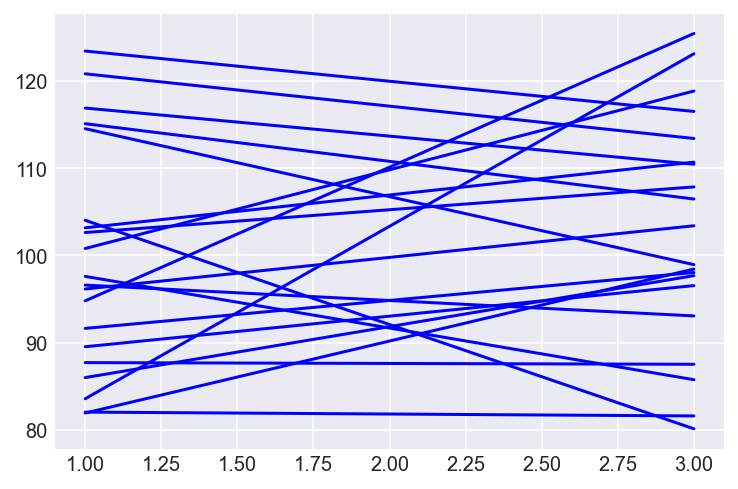

In [295]:
year = np.array([1, 2, 3])
yearbar = 2
n = 20

for i in range(n):
    sigma = np.random.exponential(1, size=n)
    beta = np.random.normal(0, 10, size=n)
    alpha = np.random.normal(100, 10, size=n)
    y = alpha[i] + beta[i] * (year - yearbar)
    plt.plot(year, y, c="blue")


### 4M5
Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

Yes, beta can't be negative, maybe we can use a log normal.

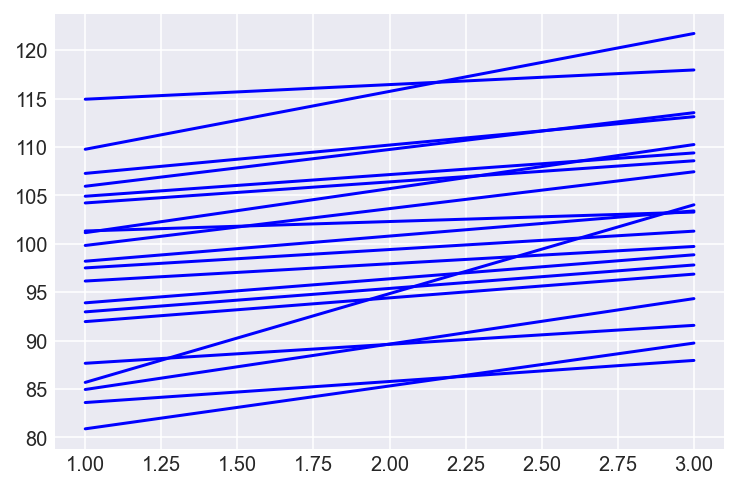

In [299]:
year = np.array([1, 2, 3])
yearbar = 2
n = 20

for i in range(n):
    sigma = np.random.exponential(1, size=n)
    beta = np.random.lognormal(1, 0.5, size=n)
    alpha = np.random.normal(100, 10, size=n)
    y = alpha[i] + beta[i] * (year - yearbar)
    plt.plot(year, y, c="blue")

<AxesSubplot:>

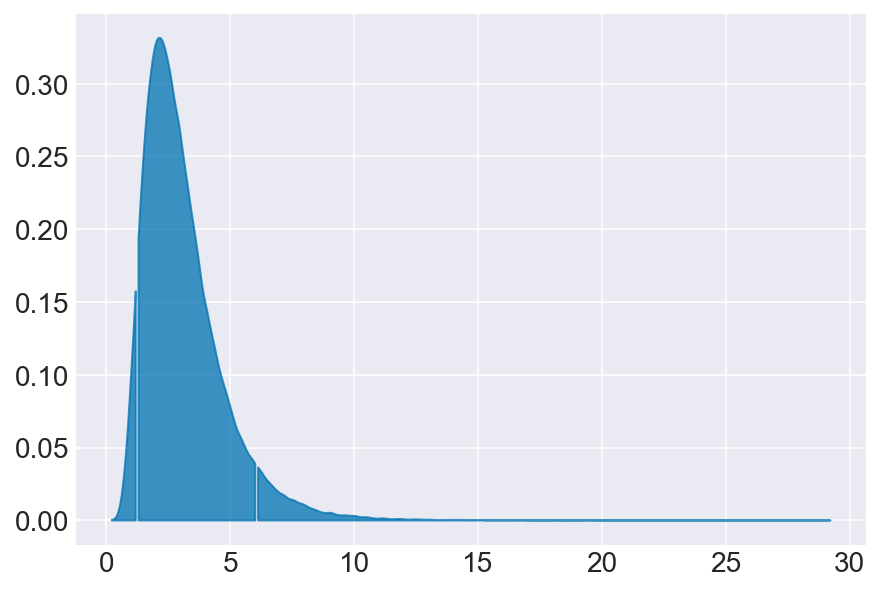

In [325]:
samples = np.random.lognormal(1, 0.5, size=100000)
l, h = pm.stats.hdi(samples, hdi_prob=0.89)
pm.plot_kde(samples, quantiles=[0.055, 0.945])

### 4M7

In [78]:
with pm.Model("m") as model:
    sigma = pm.Uniform("sigma", 0, 50)
    beta = pm.Lognormal("beta", 0, 1)
    alpha = pm.Normal("alpha", 178, 20)
    # mu = alpha + beta * d2.weight
    mu = pm.Deterministic("mu", alpha + beta * (d2.weight - d2.weight.mean()))
    height = pm.Normal("height", mu, sigma, observed=d2.height)
    trace_1 = pm.sample(1000, tune=2000)

/var/folders/5y/qjwg__qs30d10cqddlwnmbvm0000gn/T/ipykernel_94801/2132422631.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_1 = pm.sample(1000, tune=2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_alpha, m_beta, m_sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


In [60]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["height", "mu", "alpha", "beta"]
    )

# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


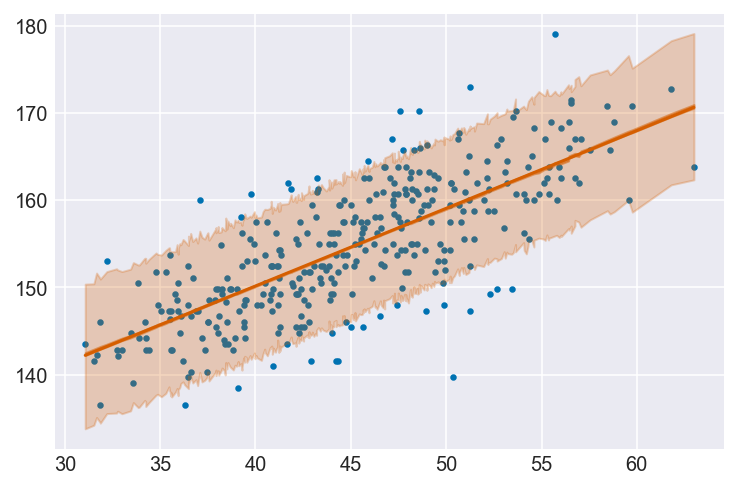

In [61]:
height_pred_hpd = pm.stats.hdi(ppc["m_height"], hdi_prob=0.89)
idx = np.argsort(d2.weight.values)
d2_weight_ord = d2.weight.values[idx]
height_pred_hpd = height_pred_hpd[idx]

mu_hdp = pm.stats.hdi(ppc["m_mu"], hdi_prob=0.2)
mu_hdp = mu_hdp[idx]

weigth_seq = np.linspace(d2.weight.min(), d2.weight.max(), 4000)
plt.plot(d2_weight_ord, ppc["m_mu"].mean(axis=0)[idx], c="C2")
plt.scatter(d2.weight, d2.height, s=5)

plt.fill_between(d2_weight_ord, mu_hdp[:,0], mu_hdp[:,1], color='C2', alpha=0.5)
plt.fill_between(d2_weight_ord, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)


### 4H1

The weights listed below were recored in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table, below, using model-based predictions.

|Individual|	weight|	expected height	   |89% interval|
|----------|----------|--------------------|------------|
| 1        | 47.0     |                    |            |
| 2        | 43.7     |                    |            |
| 3        | 64.8     |                    |            |
| 4        | 32.6     |                    |            |
| 5        | 54.6     |                    |            |


In [82]:
with model:
    new_m = pm.Deterministic("new_m_2", alpha + beta * (np.array([47, 43.7, 64.8, 32.6, 54.6]) - d2.weight.mean()))
    s = pm.sample(100, tune=100)

/var/folders/5y/qjwg__qs30d10cqddlwnmbvm0000gn/T/ipykernel_94801/660313594.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  s = pm.sample(100, tune=100)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_alpha, m_beta, m_sigma]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.929176912663822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8934719577590928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926239707113193, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879880225754019, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [85]:
s["m_new_m_2"].mean(0)

array([156.41450148, 153.41840382, 172.57527072, 143.34062076,
       163.3146052 ])

In [83]:
pm.stats.hdi(s["m_new_m_2"], hdi_prob=0.89)


/Users/alvaro/miniforge3/envs/rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


array([[155.91486201, 156.84708529],
       [153.01733459, 153.9087127 ],
       [171.18978502, 173.71444749],
       [142.51721544, 144.25329408],
       [162.65334006, 164.13735926]])

### 4H2

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

In [87]:
young_how = d[d.age < 18].copy()
young_how['weight_c'] = young_how.weight - young_how.weight.mean()
young_how.shape

(192, 5)

In [88]:
young_how.describe()

,height,weight,age,male,weight_c
count,192.000000,192.000000,192.000000,192.000000,1.920000e+02
mean,108.318853,18.414193,7.721875,0.479167,-4.440892e-16
std,25.745139,8.939313,5.366235,0.500872,8.939313e+00
min,53.975000,4.252425,0.000000,0.000000,-1.416177e+01
25%,89.128600,11.708343,3.000000,0.000000,-6.705850e+00
50%,111.125000,16.981350,7.000000,0.000000,-1.432843e+00
75%,127.723900,23.416687,12.000000,1.000000,5.002494e+00
max,158.115000,44.735511,17.000000,1.000000,2.632132e+01


In [151]:
with pm.Model("youth") as model:
    alpha = pm.Normal("alpha", 110, 10)
    beta = pm.Lognormal("beta", 0, 1)
    mu = pm.Deterministic("mu", alpha + beta * young_how.weight_c)
    # mu = alpha + beta * young_how.weight_c
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu, sigma, observed=young_how.height)
    trace = pm.sample(1000, tune=100)

/var/folders/5y/qjwg__qs30d10cqddlwnmbvm0000gn/T/ipykernel_94801/2098447382.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=100)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [youth_sigma, youth_beta, youth_alpha]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.9109394943293893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9268757832325946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9299489565947361, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9228193749996108, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [158]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["youth_height", "youth_mu"])

In [159]:
idxs = np.argsort(young_how.weight)
weight_sorted = young_how.weight.values[idxs]
pred_height = ppc["youth_height"].mean(0)[idxs]
pred_height_hdi = pm.stats.hdi(ppc["youth_height"], hdi_prob=0.89)[idxs]
pred_mu = ppc["youth_mu"].mean(0)[idxs]
pred_mu_hdi = pm.stats.hdi(ppc["youth_mu"], hdi_prob=0.89)[idxs]

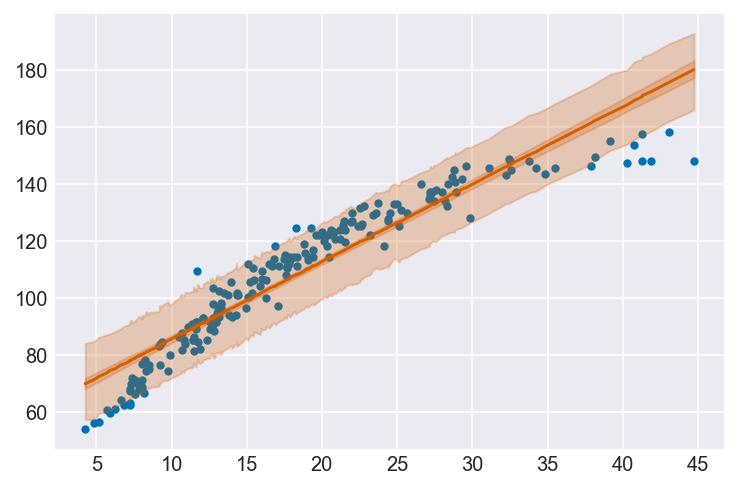

In [160]:
seq = np.linspace(young_how.weight.min(), young_how.weight.max(), len(pred_height))
plt.scatter(young_how.weight, young_how.height, s=10)
plt.plot(weight_sorted, pred_height, c="C2")
plt.fill_between(weight_sorted, pred_height_hdi[:, 0], pred_height_hdi[:, 1], color="C2", alpha=0.25)
plt.fill_between(weight_sorted, pred_mu_hdi[:, 0], pred_mu_hdi[:, 1], color="C2", alpha=0.25)

### 4H3

Suppose a colleauge of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.

Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting estimates?

In [165]:
with pm.Model("full") as model:
    alpha = pm.Normal("alpha", 158, 20)
    beta = pm.Lognormal("beta", 0, 1)
    mu = pm.Deterministic("mu", alpha + beta * (np.log(d.weight) - np.log(d.weight.mean())))
    sigma = pm.Exponential("sigma", 1)
    height = pm.Normal("height", mu, sigma, observed=d.height)
    trace = pm.sample(1000, tune=100)

/var/folders/5y/qjwg__qs30d10cqddlwnmbvm0000gn/T/ipykernel_94801/1950767489.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=100)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [full_sigma, full_beta, full_alpha]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 52 seconds.
The acceptance probability does not match the target. It is 0.9077594736103141, but should be close to 0.8. Try to increase the number of tuning steps.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4711178301741345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999743682094684, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5484522504220992, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statist

In [166]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["full_height", "full_mu"])

In [167]:
idxs = np.argsort(d.weight)
weight_sorted = d.weight.values[idxs]
pred_height = ppc["full_height"].mean(0)[idxs]
pred_height_hdi = pm.stats.hdi(ppc["full_height"], hdi_prob=0.89)[idxs]
pred_mu = ppc["full_mu"].mean(0)[idxs]
pred_mu_hdi = pm.stats.hdi(ppc["full_mu"], hdi_prob=0.89)[idxs]

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


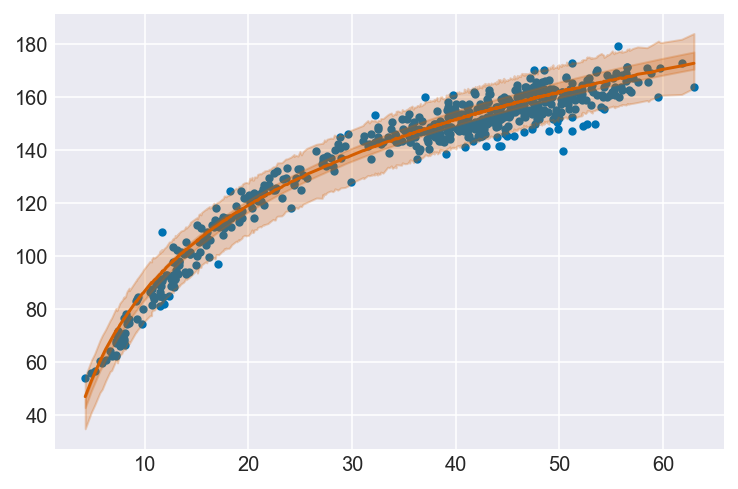

In [168]:
seq = np.linspace(d.weight.min(), d.weight.max(), len(pred_height))
plt.scatter(d.weight, d.height, s=10)
plt.plot(weight_sorted, pred_height, c="C2")
plt.fill_between(weight_sorted, pred_height_hdi[:, 0], pred_height_hdi[:, 1], color="C2", alpha=0.25)
plt.fill_between(weight_sorted, pred_mu_hdi[:, 0], pred_mu_hdi[:, 1], color="C2", alpha=0.25)